In [163]:
import polars as pl
from nltk.corpus import stopwords
import nltk
import re
import demoji

In [164]:
# Load Stopwords and the dataset
nltk.download('stopwords')
ensw = stopwords.words('english')

df = pl.read_csv("Complete_Data.csv")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helpkreios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

For the first step, we wanted to re-format the `ID` section of the data set to remove the leading zeroes.

In [165]:
# Clean ID Part
df = df.select([
    pl.col("ID").apply(lambda id: id.split("-")[1]).cast(pl.Int32),
    pl.exclude("ID")
])



Next up, we will be making sure that our dataset only contains rows that have data on both the `Tweet`  and  `Tweet Url` column

In [166]:
# Remove rows without tweet AND tweet URL
df = df.filter(pl.col("Tweet").is_not_null() & pl.col("Tweet URL").is_not_null())
df.head()


ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,Account bio,Account type,Joined,Following,Followers,Location,Tweet,Tweet Translated,Tweet Type,Date posted,Screenshot,Content type,Likes,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
i32,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str
1,"""30/12/99 05:12…","""https://twitte…",null,"""Monasterial, M…","""AQNO""","""Ninoy being li…","""ninoy npa comm…","""@arthur_vee""","""The King""","""I think, there…","""Anonymous""","""02/12""",2767,4255,"""London, Englan…","""Cory Aquino: …","""Cory Aquino: …","""Text""","""06/07/22 04:43…",null,"""Rational""",259,null,94,6,null,null,"""https://www.ra…",null,null,null
2,"""14/03/23 05:19…","""https://twitte…",null,"""Monasterial, M…","""AQNO""","""Ninoy being li…","""ninoy npa comm…","""@ItsJamMagno""","""Jam Magno""","""Ibahin niyo ak…","""Identified""","""08/15""",0,76100,"""Butuan City, P…","""Ninoy Aquino i…","""Ninoy Aquino i…","""Text""","""21/08/22 15:35…",null,"""Rational""",1231,null,271,21,null,null,"""https://www.ra…",null,null,null
3,"""14/03/23 05:24…","""https://twitte…",null,"""Monasterial, M…","""AQNO""","""Ninoy being li…","""ninoy npa comm…","""@Brad_Kardinal…","""PBBM-VPSARA Fo…","""I'm so proud o…","""Anonymous""","""09/21""",1787,2067,null,"""Ninoy is a tra…","""Ninoy is a tra…","""Text, Image""","""21/08/22 03:28…",null,"""Rational""",188,null,78,15,null,null,"""https://www.on…",null,null,null
4,"""14/03/23 05:31…","""https://twitte…",null,"""Monasterial, M…","""AQNO""","""Ninoy being li…","""ninoy npa comm…","""@WinwinEklabu""","""Mr.Winwin_Situ…","""I am proud to …","""Anonymous""","""12/15""",6462,7082,"""Metro Manila, …","""Ninoy Aquino d…","""Ninoy Aquino d…","""Text, Image""","""22/08/22 06:22…",null,"""Rational""",29,null,10,null,null,null,"""https://www.ra…",null,null,null
5,"""14/03/23 05:34…","""https://twitte…",null,"""Monasterial, M…","""AQNO""","""Ninoy being li…","""ninoy npa comm…","""@cierloX6""","""Cierlo""","""natsugi acct k…","""Anonymous""","""02/22""",542,532,null,"""ninoy aquino i…","""ninoy aquino i…","""Text""","""27/11/22 15:53…",null,"""Rational""",55,null,17,1,null,null,null,null,null,null


Since, the following columns: `Location`, `Account bio`, `Group`, `Collector`, `Category`, `Screenshot`, `Rating`, `Reasoning`, `Remarks`, `Reviewer`, `Views`, and `Review` are not needed, we will be removing them.



In [167]:
df = df.drop(['Location', 'Account bio', 'Group','Collector', 'Category','Keywords','Rating','Reasoning', 'Remarks','Reviewer','Review', 'Screenshot', 'Views'])  # Drop multiple columns

df

ID,Timestamp,Tweet URL,Topic,Account handle,Account name,Account type,Joined,Following,Followers,Tweet,Tweet Translated,Tweet Type,Date posted,Content type,Likes,Replies,Retweets,Quote Tweets,Views
i32,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,i64,i64,i64,i64,str
1,"""30/12/99 05:12…","""https://twitte…","""Ninoy being li…","""@arthur_vee""","""The King""","""Anonymous""","""02/12""",2767,4255,"""Cory Aquino: …","""Cory Aquino: …","""Text""","""06/07/22 04:43…","""Rational""",259,null,94,6,null
2,"""14/03/23 05:19…","""https://twitte…","""Ninoy being li…","""@ItsJamMagno""","""Jam Magno""","""Identified""","""08/15""",0,76100,"""Ninoy Aquino i…","""Ninoy Aquino i…","""Text""","""21/08/22 15:35…","""Rational""",1231,null,271,21,null
3,"""14/03/23 05:24…","""https://twitte…","""Ninoy being li…","""@Brad_Kardinal…","""PBBM-VPSARA Fo…","""Anonymous""","""09/21""",1787,2067,"""Ninoy is a tra…","""Ninoy is a tra…","""Text, Image""","""21/08/22 03:28…","""Rational""",188,null,78,15,null
4,"""14/03/23 05:31…","""https://twitte…","""Ninoy being li…","""@WinwinEklabu""","""Mr.Winwin_Situ…","""Anonymous""","""12/15""",6462,7082,"""Ninoy Aquino d…","""Ninoy Aquino d…","""Text, Image""","""22/08/22 06:22…","""Rational""",29,null,10,null,null
5,"""14/03/23 05:34…","""https://twitte…","""Ninoy being li…","""@cierloX6""","""Cierlo""","""Anonymous""","""02/22""",542,532,"""ninoy aquino i…","""ninoy aquino i…","""Text""","""27/11/22 15:53…","""Rational""",55,null,17,1,null
6,null,"""https://twitte…","""Ninoy being li…","""@LelangmoVlogg…","""Winnie Corpuz""","""Identified""","""11/21""",430,257,"""Yan Si NiNoy s…","""That's Ninoy h…","""Text, Image, R…","""30/12/21 14:14…","""Emotional""",0,0,0,0,null
7,"""30/12/99 21:26…","""https://twitte…","""Ninoy being li…","""@iskonglasalis…","""Benedict Excon…","""Identified""","""04/09""",2568,6097,"""Irony: The Com…","""Irony: The Com…","""Text, Reply""","""02/01/2020 02:…","""Rational""",5,0,0,0,null
8,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@mendozadino""","""Ryan Padua""","""Identified""","""07/10""",260,37,"""@senbongrevill…","""@senbagrevilla…","""Text""","""1/17/2020""","""Emotional""",0,null,0,null,null
9,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@dTnalakRiderS…","""KulasSR""","""Anonymous""","""10/16""",1519,3275,"""Meron akong hi…","""I have a suspi…","""Reply""","""Jan 23, 2020""","""Emotional""",6,null,1,0,null


We will now be checking how big our dataset is. We do this by checking `df.shape` This revealed that we have 153 unique rows to work with. However, we have some entries that have a null value. To handle this we need to check whether we can replace the null value with a value otherwise we need to fill that up. In the `Content type` column which is categoric column, we cannot simply do this. Hence, I will be reviewing the dataset and input the values manually and importing it again. On the other hand, engagement metrics that are null we can safely set to 0. 

In [168]:
df = df.fill_null(0)


In [169]:
df

ID,Timestamp,Tweet URL,Topic,Account handle,Account name,Account type,Joined,Following,Followers,Tweet,Tweet Translated,Tweet Type,Date posted,Content type,Likes,Replies,Retweets,Quote Tweets,Views
i32,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,i64,i64,i64,i64,str
1,"""30/12/99 05:12…","""https://twitte…","""Ninoy being li…","""@arthur_vee""","""The King""","""Anonymous""","""02/12""",2767,4255,"""Cory Aquino: …","""Cory Aquino: …","""Text""","""06/07/22 04:43…","""Rational""",259,0,94,6,null
2,"""14/03/23 05:19…","""https://twitte…","""Ninoy being li…","""@ItsJamMagno""","""Jam Magno""","""Identified""","""08/15""",0,76100,"""Ninoy Aquino i…","""Ninoy Aquino i…","""Text""","""21/08/22 15:35…","""Rational""",1231,0,271,21,null
3,"""14/03/23 05:24…","""https://twitte…","""Ninoy being li…","""@Brad_Kardinal…","""PBBM-VPSARA Fo…","""Anonymous""","""09/21""",1787,2067,"""Ninoy is a tra…","""Ninoy is a tra…","""Text, Image""","""21/08/22 03:28…","""Rational""",188,0,78,15,null
4,"""14/03/23 05:31…","""https://twitte…","""Ninoy being li…","""@WinwinEklabu""","""Mr.Winwin_Situ…","""Anonymous""","""12/15""",6462,7082,"""Ninoy Aquino d…","""Ninoy Aquino d…","""Text, Image""","""22/08/22 06:22…","""Rational""",29,0,10,0,null
5,"""14/03/23 05:34…","""https://twitte…","""Ninoy being li…","""@cierloX6""","""Cierlo""","""Anonymous""","""02/22""",542,532,"""ninoy aquino i…","""ninoy aquino i…","""Text""","""27/11/22 15:53…","""Rational""",55,0,17,1,null
6,null,"""https://twitte…","""Ninoy being li…","""@LelangmoVlogg…","""Winnie Corpuz""","""Identified""","""11/21""",430,257,"""Yan Si NiNoy s…","""That's Ninoy h…","""Text, Image, R…","""30/12/21 14:14…","""Emotional""",0,0,0,0,null
7,"""30/12/99 21:26…","""https://twitte…","""Ninoy being li…","""@iskonglasalis…","""Benedict Excon…","""Identified""","""04/09""",2568,6097,"""Irony: The Com…","""Irony: The Com…","""Text, Reply""","""02/01/2020 02:…","""Rational""",5,0,0,0,null
8,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@mendozadino""","""Ryan Padua""","""Identified""","""07/10""",260,37,"""@senbongrevill…","""@senbagrevilla…","""Text""","""1/17/2020""","""Emotional""",0,0,0,0,null
9,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@dTnalakRiderS…","""KulasSR""","""Anonymous""","""10/16""",1519,3275,"""Meron akong hi…","""I have a suspi…","""Reply""","""Jan 23, 2020""","""Emotional""",6,0,1,0,null


In [170]:
df1=df.select(
    pl.col("ID"),
    pl.col("Account handle"),
    pl.col("Following"),
    pl.col("Followers"),
    pl.col("Account type").str.strip(),
)

colors = {
    'Identified': 'blue',
    'Media': 'orange',
    'Anonymous': 'red'
}
print(df1)

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for account_type, color in colors.items():
    filtered_df = df.filter(pl.col('Account type') == account_type)
    fig.add_trace(go.Scatter(
        x=filtered_df['Following'],
        y=filtered_df['Followers'],
        mode='markers',
        text=filtered_df['Account handle'],
        hovertemplate='<b>%{text}</b><br>Following: %{x}<br>Followers: %{y}',
        marker=dict(
            size=10,
            color=color,
            opacity=0.7,
            line=dict(width=0.5, color='black')
        ),
        name=account_type  # Specify the name for each trace
    ))

# Customize the layout
fig.update_layout(
    title='Following vs Followers',
    xaxis_title='Following',
    yaxis_title='Followers',
    hoverlabel=dict(bgcolor='white', font_size=12),
    plot_bgcolor='white',
    legend_title='Account Type'
)




shape: (153, 5)
┌─────┬──────────────────┬───────────┬───────────┬──────────────┐
│ ID  ┆ Account handle   ┆ Following ┆ Followers ┆ Account type │
│ --- ┆ ---              ┆ ---       ┆ ---       ┆ ---          │
│ i32 ┆ str              ┆ i64       ┆ i64       ┆ str          │
╞═════╪══════════════════╪═══════════╪═══════════╪══════════════╡
│ 1   ┆ @arthur_vee      ┆ 2767      ┆ 4255      ┆ Anonymous    │
│ 2   ┆ @ItsJamMagno     ┆ 0         ┆ 76100     ┆ Identified   │
│ 3   ┆ @Brad_Kardinal   ┆ 1787      ┆ 2067      ┆ Anonymous    │
│ 4   ┆ @WinwinEklabu    ┆ 6462      ┆ 7082      ┆ Anonymous    │
│ …   ┆ …                ┆ …         ┆ …         ┆ …            │
│ 150 ┆ @MDSOnwardPH22   ┆ 7966      ┆ 12300     ┆ Anonymous    │
│ 151 ┆ @bivoc1          ┆ 5         ┆ 0         ┆ Anonymous    │
│ 152 ┆ @ManolitoMantal2 ┆ 20        ┆ 12        ┆ Anonymous    │
│ 153 ┆ @thatsthetweet00 ┆ 2032      ┆ 1117      ┆ Anonymous    │
└─────┴──────────────────┴───────────┴───────────┴──────────

In [171]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

df2 = df.select(
    pl.col("Followers"),
    pl.col("Likes"),
    pl.col("Replies"),
    pl.col("Retweets"),
    pl.col("Quote Tweets")
)

df2 = df2.fill_null(0)





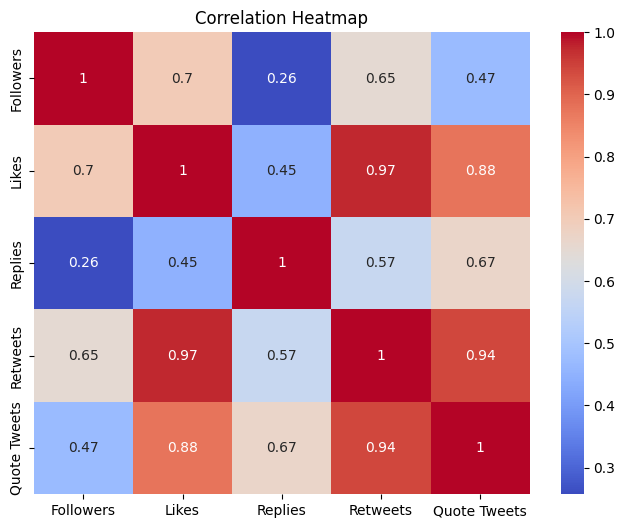

In [172]:
# Compute the correlation matrix
corr_matrix = df2.to_pandas().corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

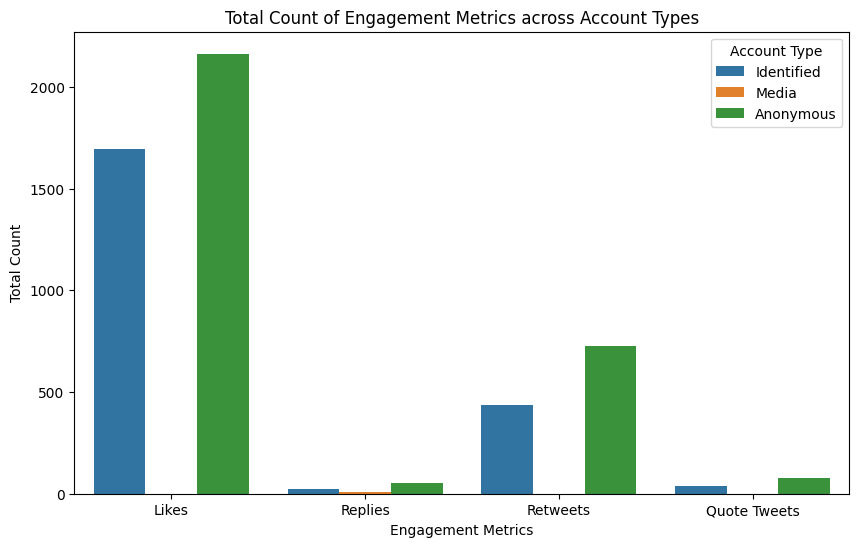

In [173]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns
df3 = df.select(
    pl.col("Account type").str.strip(),
    pl.col("Likes"),
    pl.col("Replies"),
    pl.col("Retweets"),
    pl.col("Quote Tweets")
)

# Compute the total count of engagement metrics
df_total = df3.groupby("Account type").sum()
df_total

# Reshape the data to create a long-form representation
data_melted = df_total.to_pandas().melt(
    id_vars=["Account type"],
    value_vars=["Likes", "Replies", "Retweets", "Quote Tweets"],
    var_name="Engagement",
    value_name="Total Count"
)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_melted,
    x="Engagement",
    y="Total Count",
    hue="Account type"
)
plt.title("Total Count of Engagement Metrics across Account Types")
plt.xlabel("Engagement Metrics")
plt.ylabel("Total Count")
plt.legend(title="Account Type")
plt.show()

In [174]:
data_melted

,Account type,Engagement,Total Count
0,Identified,Likes,1694
1,Media,Likes,1
2,Anonymous,Likes,2163
3,Identified,Replies,23
4,Media,Replies,9
5,Anonymous,Replies,51
6,Identified,Retweets,435
7,Media,Retweets,1
8,Anonymous,Retweets,728
9,Identified,Quote Tweets,38


In [175]:
# Include only necessary columns
df = df.select(
    pl.col("ID"),
    pl.col("Tweet"),
    pl.col("Tweet Translated").alias("Translated")
)

In [176]:
df

ID,Tweet,Translated
i32,str,str
1,"""Cory Aquino: …","""Cory Aquino: …"
2,"""Ninoy Aquino i…","""Ninoy Aquino i…"
3,"""Ninoy is a tra…","""Ninoy is a tra…"
4,"""Ninoy Aquino d…","""Ninoy Aquino d…"
5,"""ninoy aquino i…","""ninoy aquino i…"
6,"""Yan Si NiNoy s…","""That's Ninoy h…"
7,"""Irony: The Com…","""Irony: The Com…"
8,"""@senbongrevill…","""@senbagrevilla…"
9,"""Meron akong hi…","""I have a suspi…"


In [177]:
# Change tweet case to lowercase
df = df.select(
    pl.all(),
    pl.col("Translated").apply(lambda tweet: tweet.lower()).alias("Clean")
)

In [178]:
df

ID,Tweet,Translated,Clean
i32,str,str,str
1,"""Cory Aquino: …","""Cory Aquino: …","""cory aquino: …"
2,"""Ninoy Aquino i…","""Ninoy Aquino i…","""ninoy aquino i…"
3,"""Ninoy is a tra…","""Ninoy is a tra…","""ninoy is a tra…"
4,"""Ninoy Aquino d…","""Ninoy Aquino d…","""ninoy aquino d…"
5,"""ninoy aquino i…","""ninoy aquino i…","""ninoy aquino i…"
6,"""Yan Si NiNoy s…","""That's Ninoy h…","""that's ninoy h…"
7,"""Irony: The Com…","""Irony: The Com…","""irony: the com…"
8,"""@senbongrevill…","""@senbagrevilla…","""@senbagrevilla…"
9,"""Meron akong hi…","""I have a suspi…","""i have a suspi…"


In [179]:
# Remove hashtags
df = df.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(lambda tweet: re.sub("#(\w+)", '', tweet))
)

In [180]:
# Replace all emojis into interpretation
def emoji_to_word(tweet):
  for symbol, interpretation in demoji.findall(tweet).items():
    interpretation = interpretation.lower()
    # Turn flag: Philippines into flagphilippines 
    interpretation = re.sub('[^0-9a-z]+', '', interpretation)
    # replace all emojis to "emojiinterpretation "
    tweet = re.sub(symbol, interpretation+' ', tweet)
  return tweet

df = df.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(emoji_to_word)
)

In [181]:
# Remove non alphanumeric characters
df = df.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(lambda tweet: re.sub('[^0-9a-z]+', ' ', tweet))
)

In [182]:
# Cast Tweets to word array instead of long string.
df = df.select(
    pl.all(),
    pl.col("Clean").apply(lambda tweet: tweet.split()).cast(pl.List(str)).alias("Tokenized")
)

In [183]:
# Strip english stopwords
df = df.select(
    pl.all(),
    pl.col("Tokenized").arr.eval(pl.element().filter(~pl.element().is_in(ensw)), parallel=True).alias("Stopwords Removed")
)

In [184]:
# Stem and Lemmatize.
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
# Initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df = df.select(
    pl.all(),
    pl.col("Stopwords Removed").apply(lambda words: [stemmer.stem(word) for word in words.to_list()]).alias("Stemmed"),
    pl.col("Stopwords Removed").apply(lambda words: [lemmatizer.lemmatize(word) for word in words.to_list()]).alias("Lemmatized")
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helpkreios\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [185]:
print(df)
def serialize(arr):
  return " ".join(arr)
df_serialized = df.select(
    pl.col("ID"),
    pl.col("Tweet"),
    pl.col("Translated"),
    pl.col("Clean"),
    pl.col("Tokenized").apply(serialize).cast(str),
    pl.col("Stopwords Removed").apply(serialize).cast(str),
    pl.col("Stemmed").apply(serialize).cast(str),
    pl.col("Lemmatized").apply(serialize).cast(str)
)
df_serialized.write_csv("clean.csv")

shape: (153, 8)
┌─────┬─────────────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ ID  ┆ Tweet       ┆ Translated  ┆ Clean      ┆ Tokenized  ┆ Stopwords  ┆ Stemmed    ┆ Lemmatized │
│ --- ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ Removed    ┆ ---        ┆ ---        │
│ i32 ┆ str         ┆ str         ┆ str        ┆ list[str]  ┆ ---        ┆ list[str]  ┆ list[str]  │
│     ┆             ┆             ┆            ┆            ┆ list[str]  ┆            ┆            │
╞═════╪═════════════╪═════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 1   ┆ Cory        ┆ Cory        ┆ cory       ┆ ["cory",   ┆ ["cory",   ┆ ["cori",   ┆ ["cory",   │
     ┆ aquino     ┆ "aquino",  ┆ "aquino",  ┆ "aquino",  ┆ "aquino",  │
│     ┆ - Duly      ┆ - Duly      ┆ duly       ┆ … "fact"]  ┆ … "fact"]  ┆ … "fact"]  ┆ … "fact"]  │
│     ┆ elected Pr… ┆ elected     ┆ elected    ┆            ┆            ┆            ┆            │
│  